In [ ]:
# initialization
library(caret)
library(DNAshapeR)
library(ggplot2)
library(grid)

set.seed(168)

## 1. How to look into the data

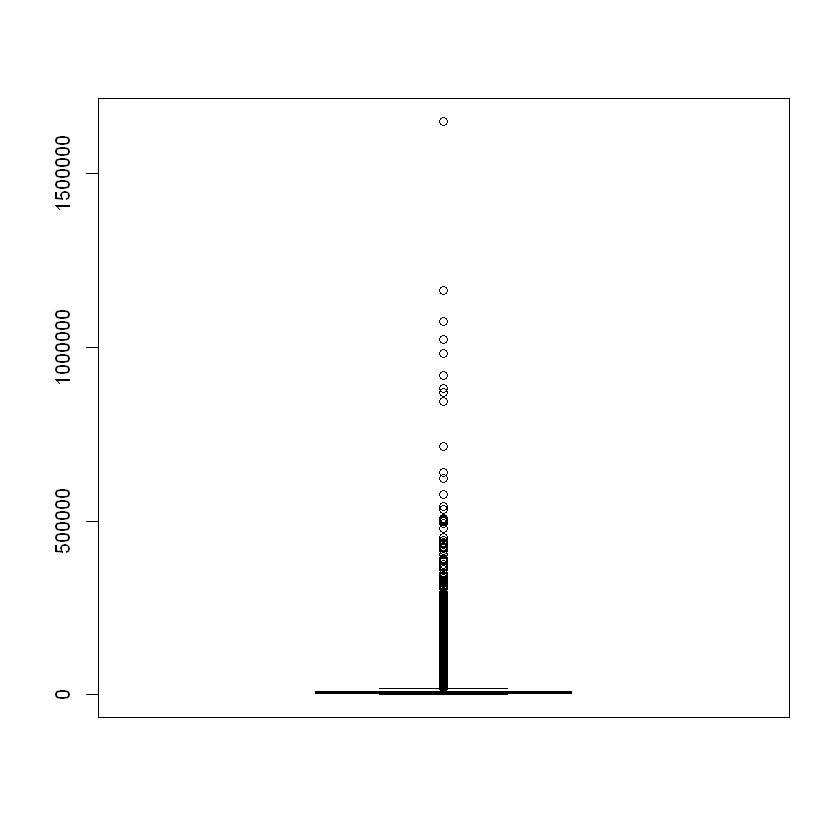

In [182]:
# load data
df <- read.csv("home_data.csv")

# 1. explore the data
head(df)
dim(df)
summary(df)
boxplot(df$sqft_lot)

In [183]:
# 2. check is there is missing data
df[is.na(df)]

character(0)

In [190]:
# 3. check data correlation
sapply(df, class)
nums <- sapply(df, is.numeric)
nums

# calculate correlations between features
cor_table <- cor(df[,nums])
cor_table

# choose features with high corrections
selected_name <- cor_table[,"price"] > 0.5
selected_name
cor_table_high_cor <- cor_table[selected_name, selected_name]
cor_table_high_cor
plot(df[,rownames(cor_table_high_cor)])

,price,bathrooms,sqft_living,grade,sqft_above,sqft_living15
price,1.0000000,0.5251375,0.7020351,0.6674343,0.6055673,0.5853789
bathrooms,0.5251375,1.0000000,0.7546653,0.6649825,0.6853425,0.5686343
sqft_living,0.7020351,0.7546653,1.0000000,0.7627045,0.8765966,0.7564203
grade,0.6674343,0.6649825,0.7627045,1.0000000,0.7559229,0.7132021
sqft_above,0.6055673,0.6853425,0.8765966,0.7559229,1.0000000,0.7318703
sqft_living15,0.5853789,0.5686343,0.7564203,0.7132021,0.7318703,1.0000000


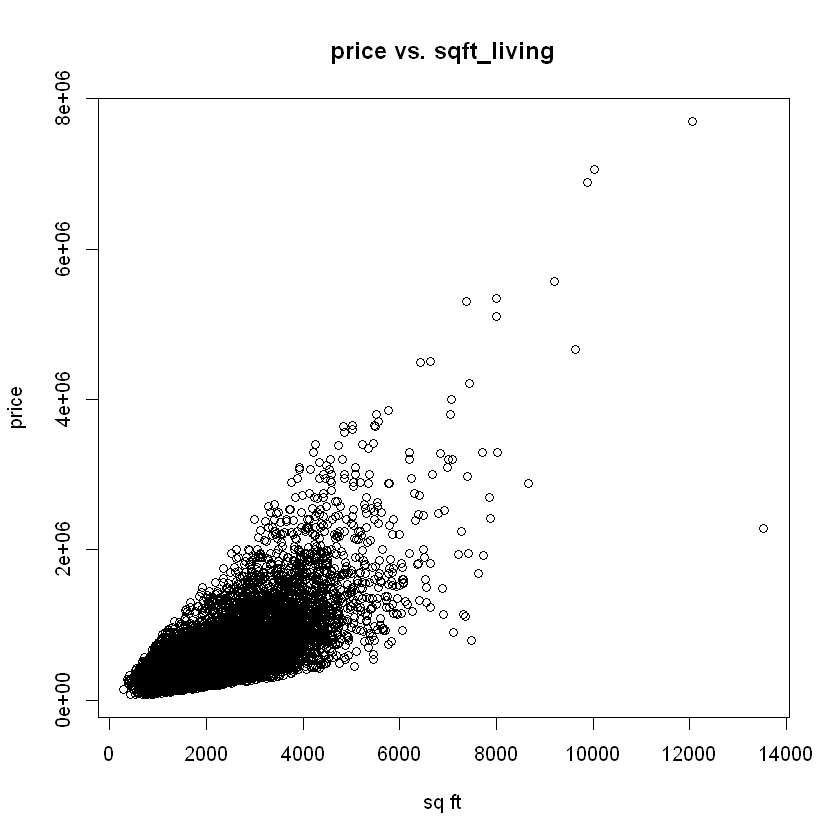

In [191]:
# plot the highest corr feature
plot(df$sqft_living, df$price, main="price vs. sqft_living", xlab="sq ft", ylab="price")

## 2. How to build a model

In [195]:
# 1. partition the data
trainIndex <- createDataPartition(df$price, p=.8, list = FALSE, times=1)
train <- df[trainIndex,]
test <- df[-trainIndex,]
#dim(train)
#dim(test)

# 2. cross validation
fitControl <- trainControl(method="cv", number=10, savePredictions=TRUE)

# 3. predict by linear regression
simplemodel <- train(price~sqft_living, train, method = "lm", trControl = fitControl)
simplemodel

Linear Regression 

17292 samples
    1 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 15562, 15563, 15563, 15564, 15563, 15563, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  257819.1  0.4919844  172695.2

Tuning parameter 'intercept' was held constant at a value of TRUE

In [196]:
train_selected <- train[,rownames(cor_table_high_cor)]
highcormodel <- train(price~., train_selected, method = "lm", trControl = fitControl)
highcormodel

Linear Regression 

17292 samples
    5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 15563, 15563, 15563, 15562, 15564, 15562, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  242800.9  0.5485294  159820.3

Tuning parameter 'intercept' was held constant at a value of TRUE

In [197]:
train_selected <- train[,nums]
allmodel <- train(price~., train_selected, method = "lm", trControl = fitControl)
allmodel

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

Linear Regression 

17292 samples
   19 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 15563, 15563, 15563, 15563, 15563, 15563, ... 
Resampling results:

  RMSE      Rsquared   MAE   
  197341.5  0.7036803  124637

Tuning parameter 'intercept' was held constant at a value of TRUE

## 3. How to assess a model

In [ ]:
simplemodelPred <- predict(simplemodel, test)
highcormodelPred <- predict(highcormodel, test)
allmodelPred <- predict(allmodel, test)

print("first model")
RMSE(simplemodelPred, test$price)
RS(simplemodelPred, test$price)

print("second model")
RMSE(highcormodelPred, test$price)
RS(highcormodelPred, test$price)

print("second model")
RMSE(allmodelPred, test$price)
RS(allmodelPred, test$price)

In [169]:
RS <- function(y_prediction, y_testing){
   1 - ( sum( y_testing - y_prediction ) ^ 2 ) / sum( (y_testing - mean( y_testing ) ) ^ 2 )  
} 

## 4. How to add regularization
We can use the R function glmnet() glmnet package for computing penalized linear regression models.

In [201]:
# Ridge regression (add l2-norm)
l2model <- train(price~., data = train_selected, trControl=fitControl, method="glmnet",
                   tuneGrid=data.frame(alpha = 0, lambda=c(2^c(-15:15))))

l2model$results
l2model$results$Rsquared[1]

#l2modelPred <- predict(l2model, test)
#RMSE(l2modelPred, test$price)


alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
0,3.051758e-05,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,6.103516e-05,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,1.220703e-04,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,2.441406e-04,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,4.882812e-04,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,9.765625e-04,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,1.953125e-03,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,3.906250e-03,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,7.812500e-03,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093
0,1.562500e-02,197505.3,0.7025481,122799.7,21440.57,0.01371716,5122.093


[1] 0.7025481

In [202]:
# Lasso regression (add l1-norm)
l1model <- train(price~., data = train_selected, trControl=fitControl, method="glmnet",
                   tuneGrid=data.frame(alpha = c(2^c(-15:0)), lambda=0))
l1model

glmnet 

17292 samples
   19 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 15565, 15562, 15563, 15563, 15563, 15563, ... 
Resampling results across tuning parameters:

  alpha         RMSE      Rsquared   MAE     
  3.051758e-05  198003.0  0.7012740  122868.6
  6.103516e-05  198002.9  0.7012734  122868.5
  1.220703e-04  198003.7  0.7012718  122868.4
  2.441406e-04  198003.8  0.7012724  122867.2
  4.882812e-04  198004.1  0.7012722  122868.2
  9.765625e-04  198007.9  0.7012675  122859.1
  1.953125e-03  197658.1  0.7019265  123531.5
  3.906250e-03  197562.4  0.7021145  124015.0
  7.812500e-03  197543.1  0.7021558  124293.1
  1.562500e-02  197545.8  0.7021546  124327.3
  3.125000e-02  197545.0  0.7021519  124332.9
  6.250000e-02  197544.2  0.7021505  124303.3
  1.250000e-01  197545.0  0.7021519  124335.6
  2.500000e-01  197548.7  0.7021437  124364.9
  5.000000e-01  197549.4  0.7021397  124389.3
  1.000000e+00  197552.8  0.7021285  124411.1

Tu

### Biological example

In [203]:
# seq model
fn <- "PBMsample.fa"
fn_exp <- "PBMsample.s"
#pred <- getShape(fn) 
featureVector <- encodeSeqShape(fn, pred, "1-mer", normalize = TRUE)

experimentalData <- read.table(fn_exp)
df <- data.frame(affinity=experimentalData$V1, featureVector)

trainControl <- trainControl(method = "cv", number = 10, savePredictions = TRUE)
model <- train(affinity~ ., data = df, trControl=trainControl, method="glmnet",
                   tuneGrid=data.frame(alpha = 0, lambda=c(2^c(-15:15))))
    
rs <- model$results$Rsquared[1]
rsd <- model$results$RsquaredSD[1]

rs
rsd

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

[1] 0.7752454

[1] 0.01116691

In [206]:
# seq + shape
featureVector <- encodeSeqShape(fn, pred, c("1-mer", "1-shape"), normalize = TRUE)

experimentalData <- read.table(fn_exp)
df <- data.frame(affinity=experimentalData$V1, featureVector)

trainControl <- trainControl(method = "cv", number = 10, savePredictions = TRUE)
model <- train(affinity~ ., data = df, trControl=trainControl, method="glmnet",
                   tuneGrid=data.frame(alpha = 0, lambda=c(2^c(-15:15))))
    
rs <- model$results$Rsquared[1]
rsd <- model$results$RsquaredSD[1]

rs
rsd

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

[1] 0.863091

[1] 0.006020799

## 4. How to compare models

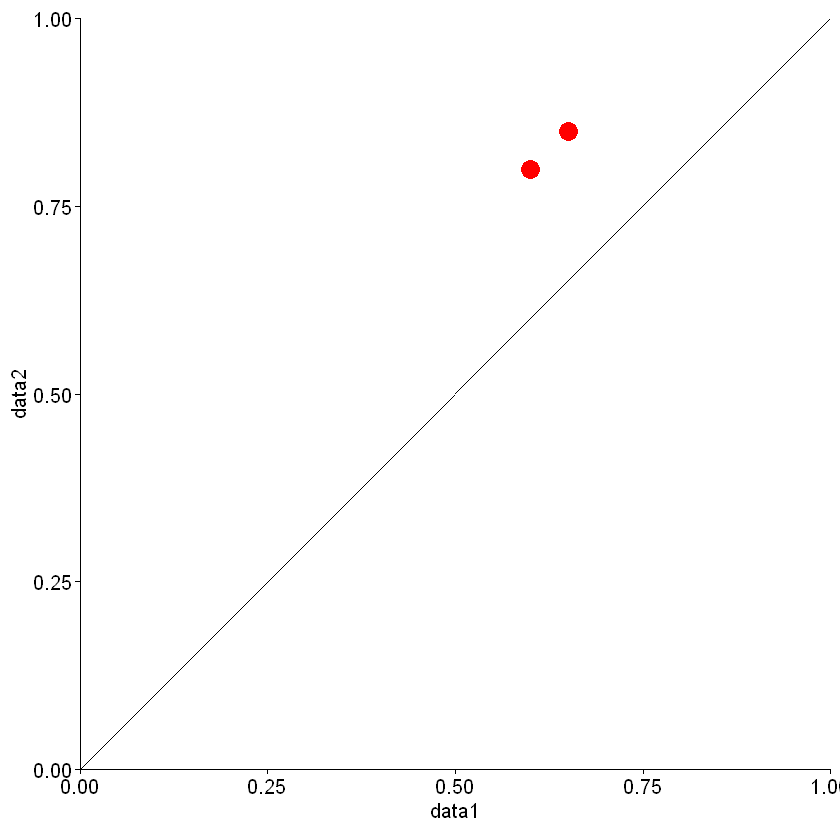

In [207]:
## Data preparation
data1 <- c(0.6, 0.65)
#Edata2 <- c(0.8, 0.85)

## Ploting
ggplot() +
  geom_point(aes(x = data1, y = data2), color = "red", size=5) +
  geom_abline(slope=1) + geom_vline(xintercept=0) + geom_hline(yintercept=0) +
  coord_fixed(ratio = 1, xlim = c(0,1), ylim = c(0,1)) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0, 0)) + my.theme 

In [ ]:
## Theme
my.theme <- theme(
  axis.text = element_text(colour="black", size=12),
  axis.title.x = element_text(colour="black", size=12),
  axis.title.y = element_text(colour="black", size=12),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
  panel.background = element_blank(),
  axis.line = element_line(colour = "black"),
#  axis.text = element_text(colour ="black"),
  axis.ticks = element_line(colour = "black"),
)